In [1]:
import os
import cv2
import time
import pathlib
import argparse
import numpy as np
import tensorflow as tf

from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow
from imutils import paths
from imutils.object_detection import non_max_suppression

In [2]:
# Mount Google Drive
gdrive = "/content/drive/"
drive.mount(gdrive)

# Akses folder
east = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Source code/frozen_east_text_detection.pb")
ran = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Dataset/dir")
model_fix1 = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Model/detection_int8.tflite")
model_fix2 = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Model/detection_float16.tflite")
model_fix3 = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Model/detection_dr.tflite")

Mounted at /content/drive/


Saving a.jpeg to a.jpeg


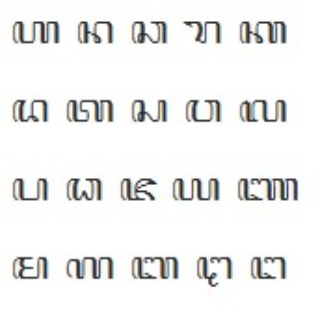

In [ ]:
uploaded = files.upload()

features = []

for fn in uploaded.keys():
    imgWidth=320
    imgHeight=320

    path = fn
    image = cv2.imread(path)

    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (imgWidth, imgHeight)

    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]
    cv2_imshow(image)

In [ ]:
net = cv2.dnn.readNet(east)

In [ ]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

In [ ]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [ ]:
net.setInput(blob)
output = net.forward(outputLayers)
scores = output[0]
geometry = output[1]

In [ ]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
  scoresData = scores[0, 0, y]
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  anglesData = geometry[0, 4, y]

  for x in range(0, numCols):
    # if our score does not have sufficient probability, ignore it
    if scoresData[x] < 0.5:
      continue

    # compute the offset factor as our resulting feature maps will
    # be 4x smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)

    # extract the rotation angle for the prediction and then
    # compute the sin and cosine
    angle = anglesData[x]
    cos = np.cos(angle)
    sin = np.sin(angle)

    # use the geometry volume to derive the width and height of
    # the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    # compute both the starting and ending (x, y)-coordinates for
    # the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    startX = int(endX - w)
    startY = int(endY - h)

    # add the bounding box coordinates and probability score to
    # our respective lists
    rects.append((startX, startY, endX, endY))
    confidences.append(scoresData[x])

In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bounding
boxes = non_max_suppression(np.array(rects), probs=confidences)

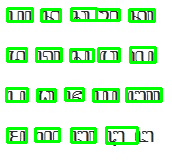

-1

In [ ]:
for (startX, startY, endX, endY) in boxes:
  # scale the bounding box coordinates based on the respective
  # ratios
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)

  # draw the bounding box on the image
  cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(orig)
cv2.waitKey(0)

In [3]:
IMAGE_LIST = list(paths.list_images(ran))
IMG_SIZE = 320

In [4]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.78, 103.94][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

In [5]:
quantization = "int8" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file=east, 
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = tflite_model = converter.convert()
tflite_model_file = pathlib.Path(model_fix1)
tflite_model_file.write_bytes(tflite_model)

24823088

In [6]:
quantization = "float16" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file=east, 
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = tflite_model = converter.convert()
tflite_model_file = pathlib.Path(model_fix2)
tflite_model_file.write_bytes(tflite_model)

48150544

In [7]:
quantization = "dr" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file=east, 
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = tflite_model = converter.convert()
tflite_model_file = pathlib.Path(model_fix3)
tflite_model_file.write_bytes(tflite_model)

24713200